## import dependencies

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import os
import requests
import zipfile
import gzip
import shutil
import glob
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
import torchvision.transforms as transforms
from torchvision import datasets
if torch.backends.mps.is_available():
    print("Using the MPS. You are good to go!")
    device = torch.device("mps")
else:
    print("Using the CPU. Overall speed may be slowed down")
    device = 'cpu'

Using the MPS. You are good to go!


## Load Data

In [450]:
import pickle
database_tr = None
with open('./DataSet/database_tr.pkl', 'rb') as f:
    database_tr = pickle.load(f)
    database_tr = database_tr[:32]
print(len(database_tr))
database_val = None
with open('./DataSet/database_val.pkl', 'rb') as f:
    database_val = pickle.load(f)
    database_val = database_val[:32]
print(len(database_val))
database_te = None
with open('./DataSet/database_te.pkl', 'rb') as f:
    database_te = pickle.load(f)
    database_te = database_te[:4]
print(len(database_te))

32
32
4


## Transformer

In [451]:
data_transform = {'train':transforms.Compose([transforms.Resize((256,256)),
                                transforms.CenterCrop(224),
                               ]),
                  'test':transforms.Compose([transforms.Resize((256,256)),
                                transforms.CenterCrop(224),
                                ]),
                 }

## Data Loader

torch.Size([4, 4, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 4, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 4, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 4, 224, 224])
torch.Size([4, 1, 224, 224])


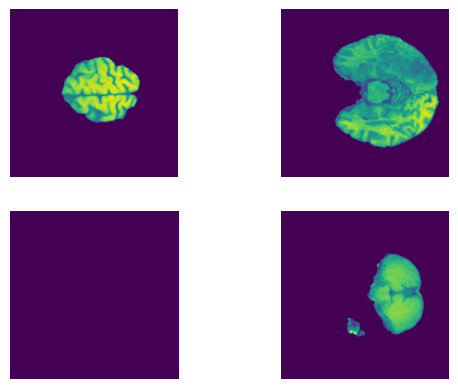

In [456]:
class BraTDataset(torch.utils.data.Dataset):
        # refer to Medical Image Segmentation with Diffusion Model, 2020, https://github.com/KidsWithTokens/MedSegDiff
    def __init__(self, database, transform, test_flag=False):
        super().__init__()
        self.transform = transform
        self.test_flag=test_flag
        self.database = database
        if test_flag:
            self.keys = ['t1', 't1ce', 't2', 'flair']
        else:
            self.keys = ['t1', 't1ce', 't2', 'flair', 'seg']

    def __len__(self):
        return len(self.database) * 155

    def __getitem__(self, x):
        out = []
        slice = x % 155
        n = x // 155
        dict = self.database[n]
        for key in self.keys:
            img = dict[key]
            op = torch.tensor(img)[...,slice]
            out.append(op)
        out = torch.stack(out)
        
        if self.test_flag:
            image=out
            if self.transform:
                image = self.transform(image)
            return (image, image)
        else:
            if self.transform:
                out = self.transform(out)
            image = out[:-1, ...]
            label = out[-1, ...][None, ...]
            label=torch.where(label > 0, 1, 0).float()
            return (image, label)

ds_tr = BraTDataset(database=database_tr, transform=data_transform['train'], test_flag=False)
ds_val = BraTDataset(database=database_val, transform=data_transform['test'], test_flag=False)
ds_te = BraTDataset(database=database_te, transform=data_transform['test'], test_flag=True)

from torch.utils.data import DataLoader
train_loader = DataLoader(ds_tr, batch_size=4, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=4, shuffle=True)
te_loader = DataLoader(ds_te, batch_size=4, shuffle=False)

fig, axes = plt.subplots(2, 2)
axes = np.reshape(axes, (4, ))
for i in range(4):
  example = train_loader.__iter__().__next__()
  image = example[0]
  label = example[1]
  print(image.shape)
  print(label.shape)
  axes[i].imshow(image[0, 0, :, :])
  axes[i].axis('off')
plt.show()

## Self-improved U-Net with batch normalization

In [457]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels // 2 + in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        dY = x2.size()[2] - x1.size()[2]
        dX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [dX // 2, dX - dX // 2, dY // 2, dY - dY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        # print("x1:", x1.shape)  # Debug
        x2 = self.down1(x1)
        # print("x2:", x2.shape)  # Debug
        x3 = self.down2(x2)
        # print("x3:", x3.shape)  # Debug
        x4 = self.down3(x3)
        # print("x4:", x4.shape)  # Debug
        x5 = self.down4(x4)
        # print("x5:", x5.shape)  # Debug
        x = self.up1(x5, x4)
        # print("After up1:", x.shape)  # Debug
        x = self.up2(x, x3)
        # print("After up2:", x.shape)  # Debug
        x = self.up3(x, x2)
        # print("After up3:", x.shape)  # Debug
        x = self.up4(x, x1)
        # print("After up4:", x.shape)  # Debug
        logit = self.outc(x)
        return logit

### Dice Loss we defined without penalty

In [461]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-30):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, labels):
        logits_bound = torch.sigmoid(logits)
        
        label_flat = labels.view(-1)
        
        logits_flat = logits_bound .view(-1)
        
        intersection = (label_flat * logits_flat).sum()
        
        dice_score = (2. * intersection + 1e-30) / (label_flat.sum() + logits_flat.sum() + 1e-30)
        
        dice_loss = 1 - dice_score
        
        return dice_loss

### model evaluation function - Dice Score

In [466]:
def evaluate(model, loader, loss_fun):
    model.eval()
    accuracy = 0
    count = 0
    with torch.no_grad():
        for batch, label in tqdm(loader):
            if len(np.unique(label)) == 1:
                continue
            batch = batch.to(device=device, dtype=torch.float)
            label = label.to(device=device, dtype=torch.float)
            pred = model(batch)
            count = count + 1
            score = 1 - loss_fun(pred, label)
            accuracy = accuracy + score 
        Accuracy = accuracy / count
        print("\n Accuracy: {}".format(Accuracy))
        return Accuracy

## Train

In [468]:
import torch.nn.init as init
model = UNet(n_channels=4, n_classes=1)
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        init.uniform(m.weight, 0, 1)
        if m.bias is not None:
            init.constant_(m.bias, 0)
            
model = model.to(device)

learning_rate, weight_decay, num_epoch = 0.1, 0, 30
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
# criterion = nn.BCEWithLogitsLoss()
criterion = DiceLoss()

def train(model, trainloader, valloader, num_epoch=10):
    trn_loss_hist = []
    trn_acc_hist = []
    val_acc_hist = []
    evaluate(model, trainloader, criterion)
    print("Start training...")
    model.train()
    for i in range(num_epoch):
        running_loss = 0.0
        model.train()
        print('-----------------Epoch = %d-----------------' % (i+1))
        count = 0
        for batch, label in tqdm(trainloader):
            if len(np.unique(label)) == 1 and count % 2 == 0:
                continue
            batch = batch.to(device=device, dtype=torch.float)
            label = label.to(device=device, dtype=torch.float)
            # print(label.shape)
            optimizer.zero_grad() 
            pred = model(batch)
            loss = criterion(pred, label)
            count = count + 1
            running_loss = running_loss + loss.item()
            loss.backward() 
            optimizer.step()
        print("\n Epoch {} loss:{}".format(i+1, running_loss/count))
        torch.save(model.state_dict(), 'model_32dice_{}.pth'.format(i+1))
        trn_loss_hist.append(running_loss/count)
        print("\n Evaluate on training set...")
        trn_acc_hist.append(evaluate(model, trainloader, criterion))
        print("\n Evaluate on validation set...")
        val_acc_hist.append(evaluate(model, valloader, criterion))
    print("Done!")
    return trn_loss_hist, trn_acc_hist, val_acc_hist

trn_loss_hist, trn_acc_hist, val_acc_hist = train(model, train_loader,
                                                  val_loader, num_epoch)

/var/folders/7l/8jkxfq0s27b8yk8tp355479r0000gn/T/ipykernel_96855/25650442.py:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  init.uniform(m.weight, 0, 1)
100%|██████████| 1240/1240 [02:12<00:00,  9.34it/s]



 Accuracy: 0.04605630412697792
Start training...
-----------------Epoch = 1-----------------


100%|██████████| 1240/1240 [03:26<00:00,  5.99it/s]



 Epoch 1 loss:0.9253725555083571

 Evaluate on training set...


100%|██████████| 1240/1240 [02:10<00:00,  9.49it/s]



 Accuracy: 0.1411500722169876

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:10<00:00,  9.48it/s]



 Accuracy: 0.12460912019014359
-----------------Epoch = 2-----------------


100%|██████████| 1240/1240 [03:20<00:00,  6.17it/s]



 Epoch 2 loss:0.8584323256312522

 Evaluate on training set...


100%|██████████| 1240/1240 [02:09<00:00,  9.59it/s]



 Accuracy: 0.1408061534166336

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:09<00:00,  9.57it/s]



 Accuracy: 0.16949991881847382
-----------------Epoch = 3-----------------


100%|██████████| 1240/1240 [03:19<00:00,  6.20it/s]



 Epoch 3 loss:0.8394204331689501

 Evaluate on training set...


100%|██████████| 1240/1240 [02:08<00:00,  9.63it/s]



 Accuracy: 0.19585244357585907

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:09<00:00,  9.58it/s]



 Accuracy: 0.16941282153129578
-----------------Epoch = 4-----------------


100%|██████████| 1240/1240 [03:20<00:00,  6.18it/s]



 Epoch 4 loss:0.8416194367530809

 Evaluate on training set...


100%|██████████| 1240/1240 [02:09<00:00,  9.60it/s]



 Accuracy: 0.18751868605613708

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:09<00:00,  9.55it/s]



 Accuracy: 0.17752660810947418
-----------------Epoch = 5-----------------


100%|██████████| 1240/1240 [03:20<00:00,  6.17it/s]



 Epoch 5 loss:0.8379888410645738

 Evaluate on training set...


100%|██████████| 1240/1240 [02:09<00:00,  9.58it/s]



 Accuracy: 0.18566513061523438

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:09<00:00,  9.59it/s]



 Accuracy: 0.17381508648395538
-----------------Epoch = 6-----------------


100%|██████████| 1240/1240 [03:20<00:00,  6.19it/s]



 Epoch 6 loss:0.8323678490032591

 Evaluate on training set...


100%|██████████| 1240/1240 [02:08<00:00,  9.63it/s]



 Accuracy: 0.15577378869056702

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:10<00:00,  9.53it/s]



 Accuracy: 0.19236770272254944
-----------------Epoch = 7-----------------


100%|██████████| 1240/1240 [03:17<00:00,  6.28it/s]



 Epoch 7 loss:0.8289924682488088

 Evaluate on training set...


100%|██████████| 1240/1240 [02:08<00:00,  9.62it/s]



 Accuracy: 0.2008981704711914

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:09<00:00,  9.57it/s]



 Accuracy: 0.18089556694030762
-----------------Epoch = 8-----------------


100%|██████████| 1240/1240 [03:22<00:00,  6.13it/s]



 Epoch 8 loss:0.8349223829932132

 Evaluate on training set...


100%|██████████| 1240/1240 [02:08<00:00,  9.62it/s]



 Accuracy: 0.11752908676862717

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:10<00:00,  9.53it/s]



 Accuracy: 0.15765953063964844
-----------------Epoch = 9-----------------


100%|██████████| 1240/1240 [03:21<00:00,  6.15it/s]



 Epoch 9 loss:0.8304056241639914

 Evaluate on training set...


100%|██████████| 1240/1240 [02:08<00:00,  9.64it/s]



 Accuracy: 0.2095993012189865

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:10<00:00,  9.51it/s]



 Accuracy: 0.17517812550067902
-----------------Epoch = 10-----------------


100%|██████████| 1240/1240 [03:18<00:00,  6.23it/s]



 Epoch 10 loss:0.8256116069351453

 Evaluate on training set...


100%|██████████| 1240/1240 [02:10<00:00,  9.52it/s]



 Accuracy: 0.2087211310863495

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:11<00:00,  9.46it/s]



 Accuracy: 0.16791966557502747
-----------------Epoch = 11-----------------


100%|██████████| 1240/1240 [03:20<00:00,  6.19it/s]



 Epoch 11 loss:0.8249199841915285

 Evaluate on training set...


100%|██████████| 1240/1240 [02:08<00:00,  9.61it/s]



 Accuracy: 0.16256511211395264

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:09<00:00,  9.57it/s]



 Accuracy: 0.19545841217041016
-----------------Epoch = 12-----------------


100%|██████████| 1240/1240 [03:20<00:00,  6.18it/s]



 Epoch 12 loss:0.8215751461876399

 Evaluate on training set...


100%|██████████| 1240/1240 [02:09<00:00,  9.56it/s]



 Accuracy: 0.2103426307439804

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:10<00:00,  9.48it/s]



 Accuracy: 0.1712968796491623
-----------------Epoch = 13-----------------


100%|██████████| 1240/1240 [03:19<00:00,  6.22it/s]



 Epoch 13 loss:0.7876170560961864

 Evaluate on training set...


100%|██████████| 1240/1240 [02:09<00:00,  9.57it/s]



 Accuracy: 0.10132409632205963

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:10<00:00,  9.52it/s]



 Accuracy: 0.11379844695329666
-----------------Epoch = 14-----------------


100%|██████████| 1240/1240 [03:19<00:00,  6.21it/s]



 Epoch 14 loss:0.7383259583994285

 Evaluate on training set...


100%|██████████| 1240/1240 [02:09<00:00,  9.55it/s]



 Accuracy: 0.09728208929300308

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:09<00:00,  9.55it/s]



 Accuracy: 0.11004623025655746
-----------------Epoch = 15-----------------


100%|██████████| 1240/1240 [03:20<00:00,  6.18it/s]



 Epoch 15 loss:0.7326617072790097

 Evaluate on training set...


100%|██████████| 1240/1240 [02:09<00:00,  9.55it/s]



 Accuracy: 0.10162965953350067

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:10<00:00,  9.53it/s]



 Accuracy: 0.107688769698143
-----------------Epoch = 16-----------------


100%|██████████| 1240/1240 [03:19<00:00,  6.23it/s]



 Epoch 16 loss:0.7182896186136005

 Evaluate on training set...


100%|██████████| 1240/1240 [02:09<00:00,  9.58it/s]



 Accuracy: 0.0980582907795906

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:10<00:00,  9.47it/s]



 Accuracy: 0.08234521001577377
-----------------Epoch = 17-----------------


100%|██████████| 1240/1240 [03:19<00:00,  6.23it/s]



 Epoch 17 loss:0.7049361210071504

 Evaluate on training set...


100%|██████████| 1240/1240 [02:08<00:00,  9.62it/s]



 Accuracy: 0.09356551617383957

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:09<00:00,  9.59it/s]



 Accuracy: 0.07607836276292801
-----------------Epoch = 18-----------------


100%|██████████| 1240/1240 [03:20<00:00,  6.18it/s]



 Epoch 18 loss:0.7101751216965863

 Evaluate on training set...


100%|██████████| 1240/1240 [02:08<00:00,  9.67it/s]



 Accuracy: 0.09743724763393402

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:10<00:00,  9.49it/s]



 Accuracy: 0.0784291997551918
-----------------Epoch = 19-----------------


100%|██████████| 1240/1240 [03:20<00:00,  6.17it/s]



 Epoch 19 loss:0.6920110495322394

 Evaluate on training set...


100%|██████████| 1240/1240 [02:09<00:00,  9.58it/s]



 Accuracy: 0.0870913565158844

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:10<00:00,  9.52it/s]



 Accuracy: 0.06022966653108597
-----------------Epoch = 20-----------------


100%|██████████| 1240/1240 [03:20<00:00,  6.18it/s]



 Epoch 20 loss:0.6723086671674088

 Evaluate on training set...


100%|██████████| 1240/1240 [02:10<00:00,  9.52it/s]



 Accuracy: 0.1359102874994278

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:10<00:00,  9.50it/s]



 Accuracy: 0.13621486723423004
-----------------Epoch = 21-----------------


100%|██████████| 1240/1240 [03:19<00:00,  6.20it/s]



 Epoch 21 loss:0.6361998013160771

 Evaluate on training set...


100%|██████████| 1240/1240 [02:09<00:00,  9.54it/s]



 Accuracy: 0.10957171767950058

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:09<00:00,  9.56it/s]



 Accuracy: 0.11344700306653976
-----------------Epoch = 22-----------------


100%|██████████| 1240/1240 [03:20<00:00,  6.20it/s]



 Epoch 22 loss:0.6159764916623292

 Evaluate on training set...


100%|██████████| 1240/1240 [02:08<00:00,  9.63it/s]



 Accuracy: 0.160146102309227

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:10<00:00,  9.53it/s]



 Accuracy: 0.14181508123874664
-----------------Epoch = 23-----------------


100%|██████████| 1240/1240 [03:21<00:00,  6.16it/s]



 Epoch 23 loss:0.5881626001803948

 Evaluate on training set...


100%|██████████| 1240/1240 [02:10<00:00,  9.51it/s]



 Accuracy: 0.21365471184253693

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:11<00:00,  9.45it/s]



 Accuracy: 0.18955907225608826
-----------------Epoch = 24-----------------


100%|██████████| 1240/1240 [03:20<00:00,  6.20it/s]



 Epoch 24 loss:0.5450855167686377

 Evaluate on training set...


100%|██████████| 1240/1240 [02:09<00:00,  9.57it/s]



 Accuracy: 0.2716820240020752

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:10<00:00,  9.50it/s]



 Accuracy: 0.23391015827655792
-----------------Epoch = 25-----------------


100%|██████████| 1240/1240 [03:20<00:00,  6.19it/s]



 Epoch 25 loss:0.5402838184102757

 Evaluate on training set...


100%|██████████| 1240/1240 [02:10<00:00,  9.51it/s]



 Accuracy: 0.3005680441856384

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:12<00:00,  9.38it/s]



 Accuracy: 0.3225981593132019
-----------------Epoch = 26-----------------


100%|██████████| 1240/1240 [03:20<00:00,  6.20it/s]



 Epoch 26 loss:0.5299464431499556

 Evaluate on training set...


100%|██████████| 1240/1240 [02:09<00:00,  9.58it/s]



 Accuracy: 0.3134661912918091

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:09<00:00,  9.58it/s]



 Accuracy: 0.3042282164096832
-----------------Epoch = 27-----------------


100%|██████████| 1240/1240 [03:19<00:00,  6.22it/s]



 Epoch 27 loss:0.5150530189404533

 Evaluate on training set...


100%|██████████| 1240/1240 [02:09<00:00,  9.56it/s]



 Accuracy: 0.3277257978916168

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:10<00:00,  9.51it/s]



 Accuracy: 0.31702566146850586
-----------------Epoch = 28-----------------


100%|██████████| 1240/1240 [03:21<00:00,  6.16it/s]



 Epoch 28 loss:0.5342520170775401

 Evaluate on training set...


100%|██████████| 1240/1240 [02:10<00:00,  9.53it/s]



 Accuracy: 0.32543453574180603

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:10<00:00,  9.52it/s]



 Accuracy: 0.3197731673717499
-----------------Epoch = 29-----------------


100%|██████████| 1240/1240 [03:22<00:00,  6.13it/s]



 Epoch 29 loss:0.5337296510613765

 Evaluate on training set...


100%|██████████| 1240/1240 [02:09<00:00,  9.57it/s]



 Accuracy: 0.312025249004364

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:10<00:00,  9.51it/s]



 Accuracy: 0.29350051283836365
-----------------Epoch = 30-----------------


100%|██████████| 1240/1240 [03:19<00:00,  6.20it/s]



 Epoch 30 loss:0.5423824855479701

 Evaluate on training set...


100%|██████████| 1240/1240 [02:10<00:00,  9.51it/s]



 Accuracy: 0.33237984776496887

 Evaluate on validation set...


100%|██████████| 1240/1240 [02:10<00:00,  9.49it/s]


 Accuracy: 0.3452182412147522
Done!


## Visualize Results

In [469]:
model = UNet(n_channels=4, n_classes=1).to(device)
model.load_state_dict(torch.load('model_32dice_30.pth'))

<All keys matched successfully>

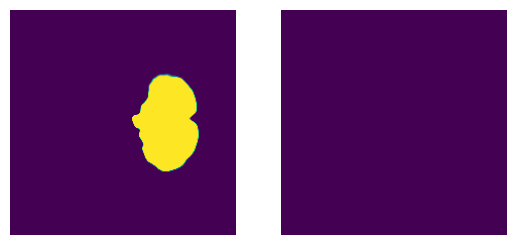

In [558]:
# evaluate(model, train_loader, criterion)
for i in range(1):
  example = val_loader.__iter__().__next__()
  image = example[0]
  image = image.to(device=device, dtype=torch.float)
  pred = model(image)
  pred = nn.Sigmoid()(pred)
  pred = pred.detach().cpu().numpy()
  label = example[1].to(device=device, dtype=torch.bool)
  label  = label.cpu().numpy()
  fig, axes = plt.subplots(1, 2)
  axes = np.reshape(axes, (2, ))
  axes[0].imshow(pred[0, 0, :, :])
  axes[0].axis('off')
  axes[1].imshow(label[0, 0, :, :])
  axes[1].axis('off')
  plt.show()

## Store result

In [565]:
print(trn_loss_hist, trn_acc_hist, val_acc_hist)
with open ('model_32dice_30.pkl', 'wb') as f:
    np.savez(f, trn_loss_hist=trn_loss_hist, trn_acc_hist=[a.cpu()  for a in trn_acc_hist], val_acc_hist=[a.cpu()  for a in val_acc_hist])

[0.9253725555083571, 0.8584323256312522, 0.8394204331689501, 0.8416194367530809, 0.8379888410645738, 0.8323678490032591, 0.8289924682488088, 0.8349223829932132, 0.8304056241639914, 0.8256116069351453, 0.8249199841915285, 0.8215751461876399, 0.7876170560961864, 0.7383259583994285, 0.7326617072790097, 0.7182896186136005, 0.7049361210071504, 0.7101751216965863, 0.6920110495322394, 0.6723086671674088, 0.6361998013160771, 0.6159764916623292, 0.5881626001803948, 0.5450855167686377, 0.5402838184102757, 0.5299464431499556, 0.5150530189404533, 0.5342520170775401, 0.5337296510613765, 0.5423824855479701] [tensor(0.1412, device='mps:0'), tensor(0.1408, device='mps:0'), tensor(0.1959, device='mps:0'), tensor(0.1875, device='mps:0'), tensor(0.1857, device='mps:0'), tensor(0.1558, device='mps:0'), tensor(0.2009, device='mps:0'), tensor(0.1175, device='mps:0'), tensor(0.2096, device='mps:0'), tensor(0.2087, device='mps:0'), tensor(0.1626, device='mps:0'), tensor(0.2103, device='mps:0'), tensor(0.1013,